In [174]:
module RobotWorld

    using Plots
    using Parameters
    using Printf

    @with_kw mutable struct Agent
        nu::Float64
        omega::Float64
        Agent(nu, omega) = new(nu, omega)
    end

    @with_kw mutable struct Landmark
        pos::Array{Float64}
        id::Int64
        Landmark(pos, id=-1) = new(pos, id)
    end

    @with_kw mutable struct Map
        landmarks::Array{Landmark}
        Map(landmarks=[]) = new(landmarks)
    end

    @with_kw mutable struct IdealCamera
        map::Map
        distance_range::Array{Float64}
        direction_range::Array{Float64}
        lastdata
        IdealCamera(map, distance_range=[0.5 6.0], direction_range=[-pi/3 pi/3], lastdata=[]) = new(map, distance_range, direction_range, lastdata)
    end

    @with_kw mutable struct IdealRobot
        pose::Array{Float64}
        color::Symbol
        r::Float64
        agent::Agent
        sensor::IdealCamera
        poses::Array{Array{Float64}}
        IdealRobot(pose, color, r, agent, sensor=IdealCamera(Map()), poses=[pose]) = new(pose, color, r, agent, sensor, poses)
    end

    @with_kw mutable struct World
        time_span::Float64
        time_interval::Float64
        fps::Int64
        objects::Array{Union{IdealRobot, Map}}
        World(time_span, time_interval, fps=10, objects=[]) = new(time_span, time_interval, fps, objects)
    end

    function visible(self::IdealCamera, observation=[]) # ランドマークが計測できる条件
        if isempty(observation) 
            return false
        end
        
        is_visible = self.distance_range[1] <= observation[1] <= self.distance_range[2] && self.direction_range[1] <= observation[2] <= self.direction_range[2]
    
        return is_visible
    end

    function data(self::IdealCamera, cam_pose)
        observed = Dict()
        for lm in self.map.landmarks
            observation = observation_function(self, cam_pose, lm.pos)
                
            if visible(self, observation)
                observed[lm.id] = deepcopy(observation)
            end
        end
    
        self.lastdata = deepcopy(observed)
        return observed
    end

    function observation_function(self::IdealCamera, cam_pose, obj_pos)
        diff = obj_pos - cam_pose[1:2]
        phi = atan(diff[2], diff[1]) - cam_pose[3]      
    
        while phi >= pi
            phi = phi - 2*pi
        end
        while phi < -pi
            phi = phi + 2*pi
        end
    
        return [hypot(diff...) phi]
    end

    function decision(agent::Agent, observation=0)
        return agent.nu, agent.omega
    end

    function state_transition(nu, omega, time, pose)
        t0 = pose[3]
        if abs(omega) < 1e-10
            return pose + [nu * cos(t0), nu * sin(t0), omega] .* time
        else
            return pose + [nu / omega * (sin(t0 + omega*time) - sin(t0)), nu/omega*(-cos(t0+omega*time)+cos(t0)), omega*time]
        end
    end

    function append(self::World, obj::IdealRobot)
        push!(self.objects, deepcopy(obj))
    end

    function append(self::World, obj::Map)
        push!(self.objects, deepcopy(obj))
    end

    function append(self::Map, landmark::Landmark)
        landmark.id = length(self.landmarks) + 1
        push!(self.landmarks, deepcopy(landmark))
    end

    function circle_shape(x, y, r)
        theta = LinRange(0, 2pi, 500)
        x .+ r * sin.(theta), y .+ r * cos.(theta)
    end

    function draw(self::World)

        # initialize a plot
        plt = plot(
            1,
            label="", 
            aspectratio=1,
            xlim=(-5, 5),
            ylim=(-5, 5),
            xlabel="X", 
            ylabel="Y"
        )
    
        anim = Animation()
        for i=1:Int64(self.time_span/self.time_interval)
            one_step(self, i, plt, anim)
        end    
        gif(anim, fps = self.fps)
        
    end

    function draw(self::IdealRobot, plt)
        x, y, theta = self.pose
        xn = x + self.r * cos(theta)
        yn = y + self.r * sin(theta)
        push!(self.poses, deepcopy(self.pose))
        
        plot!(plt, [x, xn], [y, yn], c=self.color, label="")
        plot!(plt, circle_shape(x, y, self.r), seriestype=[:shape,], c=self.color, linecolor=:black, fillalpha=0.2, aspectratio=1, label="")
        plot!(plt, [p[1] for p in self.poses], [p[2] for p in self.poses], c=self.color, label="") 
    
        if length(self.sensor.map.landmarks) > 0
            draw(self.sensor, self.poses[end-1], plt) #1ステップ前の姿勢を使用; self.sensor.lastdataに対応させるため
        end
    end

    function draw(self::Landmark, plt)
        plot!(plt, [self.pos[1]], [self.pos[2]], c=:orange, markershape=:star5, label="")        
    end

    function draw(self::Map, plt)
        for lm in self.landmarks
            draw(lm, plt)
        end
    end

    function draw(self::IdealCamera, cam_pose, plt)
        for (key, value) in self.lastdata
            x, y, theta = cam_pose
            distance = value[1] 
            direction = value[2]
                
            lx = x + distance * cos(direction + theta)
            ly = y + distance * sin(direction + theta)
        
            xx = LinRange(x, lx, 3)
            yy = LinRange(y, ly, 3)
            plot!(plt, xx, yy, color=:pink, label="")
        end
    end

    function one_step(self::World, i, plt, anim)        
        plt = plot(plt, annotation = (-3.5, 4.5, "t = "*@sprintf("%3.1f", (i-1)*self.time_interval), :black))    
        for obj in self.objects
            draw(obj, plt)
            one_step(obj, self.time_interval)
        end
        frame(anim, plt)
    end

    function one_step(self::IdealRobot, time_interval)
        obs = data(self.sensor, self.pose)
        nu, omega = decision(self.agent, obs)
        self.pose = state_transition(nu, omega, time_interval, self.pose)        
    end

    function one_step(self::Map, time_interval)
    end

end

Main.RobotWorld

┌ Info: Saved animation to 
│   fn = /home/szmlb/workspace/github/code-practice/julia/detailed_probo/src/tmp.gif
└ @ Plots /home/szmlb/.julia/packages/Plots/FI0vT/src/animation.jl:114


Plots.AnimatedGif("/home/szmlb/workspace/github/code-practice/julia/detailed_probo/src/tmp.gif")
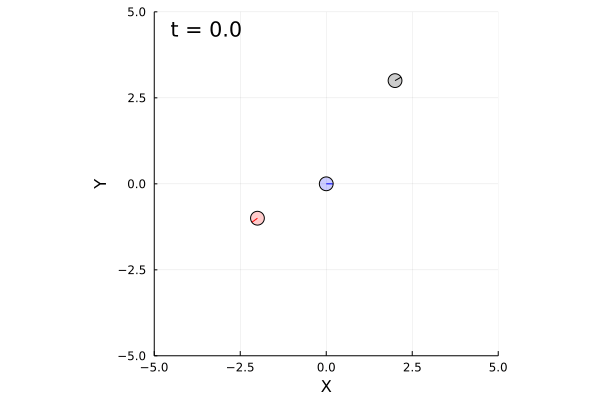

In [175]:
using .RobotWorld
world = RobotWorld.World(36, 1)

straight = RobotWorld.Agent(0.2, 0.0) # 0.2[m/s]で直進
circling = RobotWorld.Agent(0.2, 10.0/180.0*pi) # 0.2[m/s], 10[deg/s](円を描く)
stationary = RobotWorld.Agent(0.0, 0.0)
robot1 = RobotWorld.IdealRobot([2, 3, pi/6], :black, 0.2, straight)
robot2 = RobotWorld.IdealRobot([-2, -1, pi/5*6], :red, 0.2, circling)
robot3 = RobotWorld.IdealRobot([0, 0, 0], :blue, 0.2, stationary)

RobotWorld.append(world, robot1)
RobotWorld.append(world, robot2)
RobotWorld.append(world, robot3)
RobotWorld.draw(world)

┌ Info: Saved animation to 
│   fn = /home/szmlb/workspace/github/code-practice/julia/detailed_probo/src/tmp.gif
└ @ Plots /home/szmlb/.julia/packages/Plots/FI0vT/src/animation.jl:114


Plots.AnimatedGif("/home/szmlb/workspace/github/code-practice/julia/detailed_probo/src/tmp.gif")
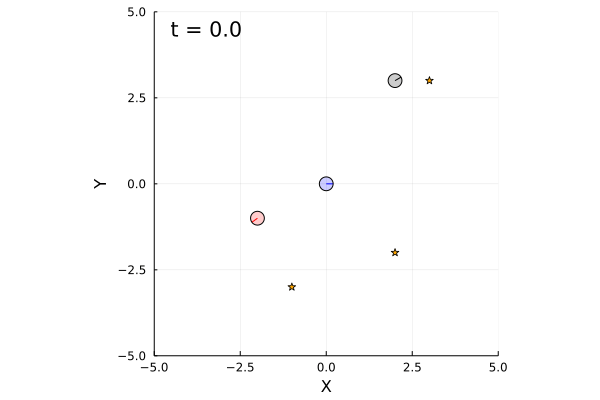

In [176]:
using .RobotWorld
world = RobotWorld.World(10, 1)

### 地図を生成して３つランドマークを追加 ###
m = RobotWorld.Map()
RobotWorld.append(m, RobotWorld.Landmark([2, -2]))
RobotWorld.append(m, RobotWorld.Landmark([-1, -3]))
RobotWorld.append(m, RobotWorld.Landmark([3, 3]))
RobotWorld.append(world, m)

stationary = RobotWorld.Agent(0.0, 0.0)
robot1 = RobotWorld.IdealRobot([2, 3, pi/6], :black, 0.2, stationary)
robot2 = RobotWorld.IdealRobot([-2, -1, pi/5*6], :red, 0.2, stationary)
robot3 = RobotWorld.IdealRobot([0, 0, 0], :blue, 0.2, stationary)

RobotWorld.append(world, robot1)
RobotWorld.append(world, robot2)
RobotWorld.append(world, robot3)

### アニメーション実行 ###
RobotWorld.draw(world)

┌ Info: Saved animation to 
│   fn = /home/szmlb/workspace/github/code-practice/julia/detailed_probo/src/tmp.gif
└ @ Plots /home/szmlb/.julia/packages/Plots/FI0vT/src/animation.jl:114


Plots.AnimatedGif("/home/szmlb/workspace/github/code-practice/julia/detailed_probo/src/tmp.gif")
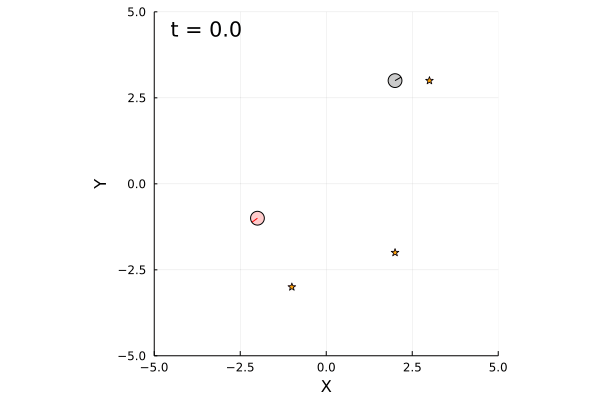

In [177]:
using .RobotWorld
world = RobotWorld.World(36, 0.1, 20)

### 地図を生成して３つランドマークを追加 ###
m = RobotWorld.Map()
RobotWorld.append(m, RobotWorld.Landmark([2, -2]))
RobotWorld.append(m, RobotWorld.Landmark([-1, -3]))
RobotWorld.append(m, RobotWorld.Landmark([3, 3]))
RobotWorld.append(world, m)

### ロボットを作る ###
straight = RobotWorld.Agent(0.2, 0.0)
circling = RobotWorld.Agent(0.2, 10.0/180.0*pi)
stationary = RobotWorld.Agent(0.0, 0.0)
robot1 = RobotWorld.IdealRobot([2, 3, pi/6], :black, 0.2, straight, RobotWorld.IdealCamera(m))
robot2 = RobotWorld.IdealRobot([-2, -1, pi/5*6], :red, 0.2, circling, RobotWorld.IdealCamera(m))

RobotWorld.append(world, robot1)
RobotWorld.append(world, robot2)

### アニメーション実行 ###
RobotWorld.draw(world) # センサ計測結果の描画は１サンプル遅れている